# Ex09 - Técnicas de segmentação

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from PIL import Image
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftn
from scipy import signal
import sys,os
ia898path = os.path.abspath('../../')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import ia898.src as ia

### Parte 1 - Segmentando múltiplos objetos por limiarização

A limiarização também pode ser feita em imagens com mais de um objeto e usando limiares múltiplos. Tente segmentar separadamente a cartela de comprimidos em uma imagem e os comprimidos em outra. Utilize o hstograma da imagem para escolher os limiares.

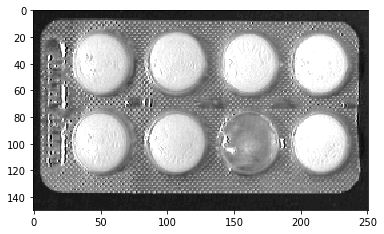

In [3]:
img = mpimg.imread('../data/astablet.tif')
plt.imshow(img, cmap='gray')

Para começar, necessitamos do histograma da imagem. Para tanto, vamos observar o formato dos dados:

In [4]:
#dimensões
print("Dimensões da imagem: ",img.shape)
#maior e menor valor
print("Maior valor:",img.max())
print("Menor valor:",img.min())
#tipo de dados
print(img.dtype)

Dimensões da imagem:  (150, 251)
Maior valor: 255
Menor valor: 0
uint8


(256,)


<BarContainer object of 256 artists>

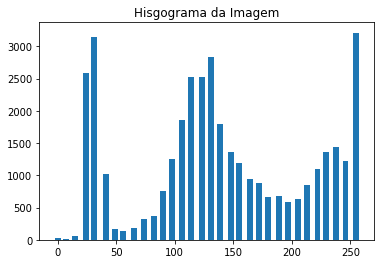

In [101]:
img2 = ia.normalize(img,[0,255])

h2 = ia.histogram(img2)
print(h2.shape)
#existem 2^8 = 256 níveis de cinza na imagem (tipo de dados: inteiro de 8 bits)
x = np.arange(256)

plt.title("Hisgograma da Imagem")
plt.bar(x,h2,width=5)

Observando a imagem, há 3 picos de ocorrências de tons de cinza. O primeiro, mais próximo de zero, representa o fundo da imagem, que é escuro. O segundo, na faixa de valores entre 100 e 150, deve representar a própria cartela de medicamentos. O Terceiro, mais próximo de 255, corresponde aos tons de cinza dos comprimidos. Sendo assim, será possível fazer a separação através da limiarização separando as faixas de intervalos as quais deseja-se separar.

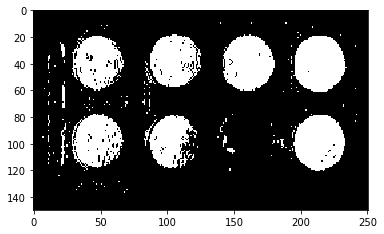

In [102]:
lim = 220

seg1 = img2 > lim

plt.imshow(seg1,'gray')

Depois de separar os comprimidos, faremos a separação da cartela a partir da imagem da primeira limiarização. Assim, podemos fazer uma segunda limiarização para a obtenção dos tons correspondentes a cartela e aos comprimidos, e usar a função lógica **XOR** para separar os comprimidos depois:

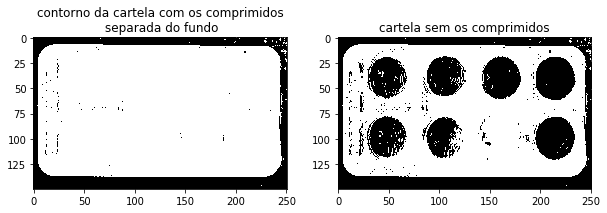

In [105]:
lim2 = 45
seg2 = (img2 > lim2) 


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('contorno da cartela com os comprimidos\n separada do fundo')
plt.imshow(seg2,'gray')


seg3 = seg2 ^ seg1

plt.subplot(122)
plt.title('cartela sem os comprimidos')
plt.imshow(seg3,'gray')

### Parte 2 - Demonstração da limiarização por Otsu

Tente melhorar a demonstração da limiarização por Otsu ([Demo](../master/otsudemo.ipynb)).

In [9]:
from math import pi, sin, cos, atan
import matplotlib.colors as pltc

O primeiro passo para a execução da limiarização por Otsu é a obtenção do Histograma da Imagem:

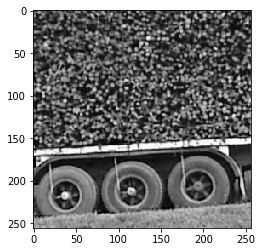

In [10]:
f1=mpimg.imread('../data/woodlog.tif')

plt.imshow(f1,'gray')

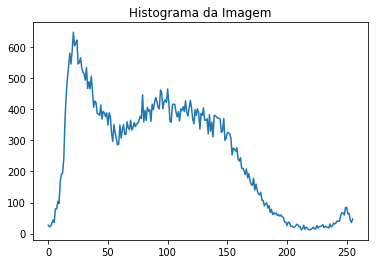

In [11]:
H1 = ia.histogram(f1)
x1 = np.arange(len(H1))
k = x1[0:-1]

plt.figure()
plt.title('Histograma da Imagem')
plt.plot(x1,H1)

A limiarização de Otsu necessita de algumas informações estatísticas da Imagem, como a variância e o nível médio de cinza. Tais informações podem ser obtidas a partir do histograma normalizado, já que ao dividir o histograma pelo número de pixels da imagem, ele pode ser visto como uma **distribuição de probabilidade**:


$$ h(t)=\frac{H}{n} $$
$$ \sum_{t=0}^{n-1} h(t)=1$$
$$ \mu=\sum_{t=0}^{n-1} th(t)$$
$$ \sigma^2=\sum_{t=0}^{n-1} (t-\mu)^2h(t)$$

1.0
mean is  91.02583312988281
var2 is  2873.8617136308476


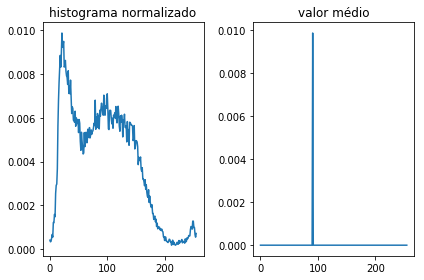

In [12]:
h = 1.*H1/np.product(f1.shape)
print(sum(h))
mt = sum(x1 * h)
st2 = sum((x1-mt)**2 * h)

if abs(mt - np.mean(np.ravel(f1))) > 0.01: iaerror('error in computing mean')

if abs(st2 - np.std(np.ravel(f1))**2) > 0.0001: iaerror('error in computing var')

print('mean is ',mt)
print('var2 is ',st2)
 
maux = np.zeros(h.shape)
maux[int(mt)] = max(h)
plt.subplot(121)
plt.title("histograma normalizado")
plt.plot(x1,h)
plt.subplot(122)
plt.title("valor médio")
plt.plot(x1,maux)

plt.tight_layout()

Na aplicação deste método, vamos supor uma distribuição **bimodal**, ou seja, os pixels estarão agrupados em duas classes (objeto e fundo, por exemplo). Utilizando o limiar t para o nível de cinza de separação, verificaremos que uma das classes será a de valores menores ou iguais a t e a outra com valores de escala de cinza maiores que t.

Assim, a probabilidade de ocorrência da primeira classe é o histograma cumulativo normalizado, e a outra classe é a classe complementar:

$$ \omega_0(t)=\sum_{i=0}^{t} h(i)$$
$$ \omega_1(t)=\sum_{t+1}^{n-1} h(i)$$

Aqui, calcularemos os valores de $ \omega_0(t) $ e $ \omega_1(t) $ :

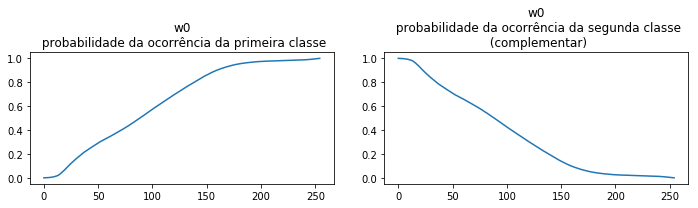

In [13]:
w0 = np.cumsum(h[0:-1])
aux = h[1::]
w1aux = np.cumsum(aux[::-1])[::-1]
w1 = 1 - w0
if max(abs(w1-w1aux)) > 0.0001: iaerror('error in computing w1')
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(k,w0)
plt.title("w0\n probabilidade da ocorrência da primeira classe")
plt.subplot(122)
plt.title("w0\n probabilidade da ocorrência da segunda classe\n (complementar)")

plt.plot(k,w1)

plt.tight_layout()

# Nível de cinza médio de cada classe

O Nível de cinza médio pode ser expressado como uma função da limiarização t. As expressões abaixo mostram como calculá-lo:

$$ \mu_0(t)=\frac{1}{\omega_0(t)}\sum_{i=0}^{t} ih(i)$$
$$ \mu_1(t)=\frac{1}{\omega_1(t)}\sum_{i=t+1}^{n-1} ih(i)$$

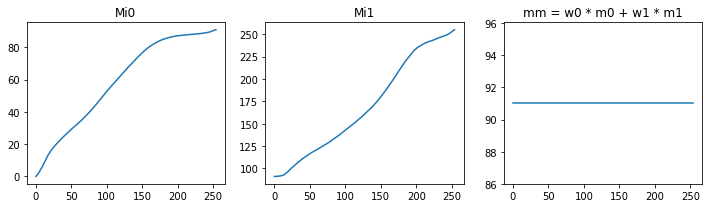

In [14]:
m0 = np.cumsum(k * h[0:-1]) / (1.*w0)
m1 = (mt - m0*w0)/w1
aux = (k+1) * h[1::]
m1x = np.cumsum(aux[::-1])[::-1] / (1.*w1)
mm = w0 * m0 + w1 * m1
if max(abs(m1-m1x)) > 0.0001: iaerror('error in computing m1')


plt.figure(figsize=(10,3))
plt.subplot(131)
plt.title("Mi0")
plt.plot(k,m0)
plt.subplot(132)
plt.title("Mi1")
plt.plot(k,m1)
plt.subplot(133)
plt.title("mm = w0 * m0 + w1 * m1")
plt.plot(k,mm)

plt.tight_layout()

# Variância de cada classe

A variância de cada classe pode como uma função da limiarização t  pode ser calculada da seguinte forma:


$$ \sigma_0^2(t)=\frac{1}{\omega_0(t)}\sum_{i=0}^{t} (i-\mu_0(t))^2h(i)$$
$$ \sigma_1^2(t)=\frac{1}{\omega_1(t)}\sum_{i=t+1}^{n-1} (i-\mu_1(t))^2h(i)$$

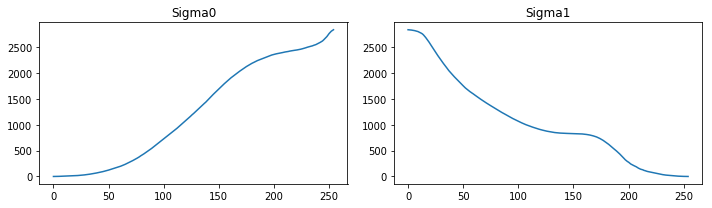

In [15]:
s02 = np.cumsum((k-m0)**2 * h[0:-1]) / (1.*w0)
aux = ((k+1)-m1)**2 * h[1::]
s12 = np.cumsum(aux[::-1])[::-1] / (1.*w1)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title("Sigma0")
plt.plot(k,s02)

plt.subplot(122)
plt.title("Sigma1")
plt.plot(k,s12)

plt.tight_layout()

# Separabilidade de classes

A variância intra-classe é uma forma eficiente de medir a separabilidade de classes. Quanto maior o seu valor, melhor é a clusterização da clase. 


$$\sigma_B^2(t)=\omega_0(t)(\mu_0(t)-\mu)^2+\omega_1(t)(\mu_1(t)-\mu)^2$$
$$\sigma_B^2(t)=\omega_0(t)\omega_1(t)(\mu_0(t)-\mu_1(t))^2$$

Optimum threshold at 93
Quality factor 0.6943198381978049


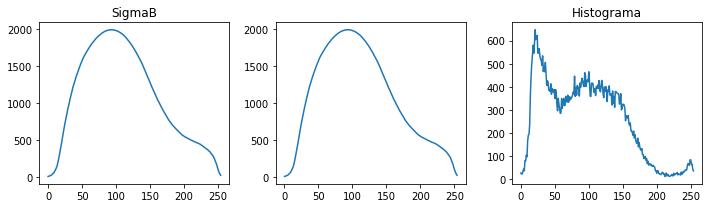

In [16]:
sB2 = w0 * ((m0 - mt)**2) + w1 * ((m1 - mt)**2)
sBaux2 = w0 * w1 * ((m0 - m1)**2)
if max(sB2-sBaux2) > 0.0001: iaerror('error in computing sB')
t = np.argmax(sB2)
eta = 1.*sBaux2[t]/st2
print('Optimum threshold at',t)
print('Quality factor', eta)

plt.figure(figsize = (10,3))
plt.subplot(131)
plt.title("SigmaB")
plt.plot(k,sB2)
plt.subplot(132)
plt.plot(k,sBaux2)
plt.subplot(133)
plt.title("Histograma")
plt.plot(k,H1[0:-1])

plt.tight_layout()

# Limiarização

Vamos mostrar o resultado da aplcação do Método de Otsu para a limiarização na imagem a seguir:

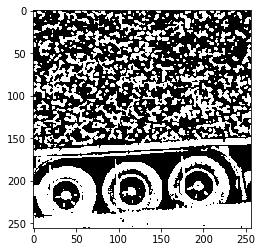

In [141]:
xlim = plt.imshow(f1 > t,cmap='gray')

### Resumo do Método

1. Calculo do Histograma Normalizado da imagem que se deseja fazer a limiarização
2. Cálculo das somas cumulativas
3. Cálculo das médias cumulativas
4. Cáclulo da média de nível de cinza global
5. Cálculo da variância intra classe
6. Obtenção do Limiar de Otsu
7. Obtenção da medida de separabilidade $\eta$


Por fim, segue a implementação da função da limiarização de Otsu, que recebe como entrada uma imagem e retorna o limiar t e a medida de separabilidade $\eta$ :

In [142]:
def otsu(f):
     n = np.product(np.shape(f))
     h = 1.*np.bincount(f.ravel()) / n  
     if len(h) == 1: return 1,1
     x = np.arange(np.product(np.shape(h)))
     w0 = np.cumsum(h)
     w1 = 1 - w0
     eps = 1e-10
     m0 = np.cumsum(x * h) / (w0 + eps)
     mt = m0[-1]
     m1 = (mt - m0[0:-1]*w0[0:-1]) / w1[0:-1]
     sB2 = w0[0:-1] * w1[0:-1] * ((m0[0:-1] - m1)**2)
     #limiar ótimo de Otsu
     t = np.argmax(sB2)
     v = sB2[t]
     st2 = sum((x-mt)**2 * h)
     #eta: grau de separabilidade das classes
     eta = v / st2
     return t, eta


Aqui analisaremos se a imagem que vamos utilizar tem um histograma coerente para o método de Otsu.

A limiarização do método de Otsu pode ser aplicada para imagens com histograma de distribuição bimodal, em que os dois picos são separados por um vale bem acentuado. Se a area dos objetos é muito pequena quando comparada ao fundo da imagem, o histograma deixa de ser bimodal, e asssim as variâncias do objeto e do fundo são grandes quando comparadas ao valor médio da diferença. Há também a possibilidade da imagem possuir ruído aditivo, o que também contribui para que os vales do histograma fiquem deformados. Dessa forma, podem ocorrer erros de segmentação no algoritmo de Otsu, com a determinação incorreta do limiar.

ler mais sobre em: https://en.wikipedia.org/wiki/Otsu%27s_method e em R. WOODS, R. GONZALES "Digital Image Processing"

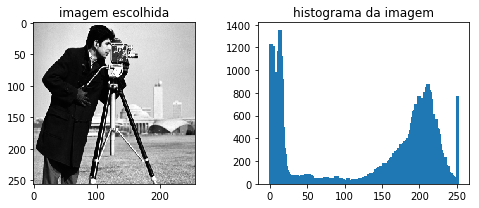

In [19]:
yt = mpimg.imread('../data/cameraman.tif')
histo = ia.histogram(yt)
#print(histo.size)
xh = np.arange(histo.size)
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.title('imagem escolhida')
plt.imshow(yt,'gray')
plt.subplot(122)
plt.title('histograma da imagem')
plt.bar(xh,histo,width=5)

plt.tight_layout()

In [20]:
teste = mpimg.imread('../data/cameraman.tif')

limiar, b = otsu(teste)

teste_lim = teste > limiar

print(f"Limiar de Otsu: {limiar}\nValor de eta: {b}")

Limiar de Otsu: 108
Valor de eta: 0.908558781070157


O valor de aproximadamente 0,694 obtido para $\eta$ indica a facilidade da separabilidade de classes no processo de limiarização.

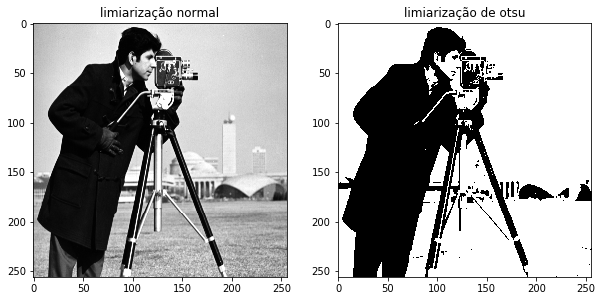

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('limiarização normal')
plt.imshow(yt,'gray')
plt.subplot(122)
plt.title('limiarização de otsu')
plt.imshow(teste_lim,'gray')

Para tentar melhorar o histograma da imagem, podemos tentar aplicar um filtro de média sobre ela:

limiar obtido: 110


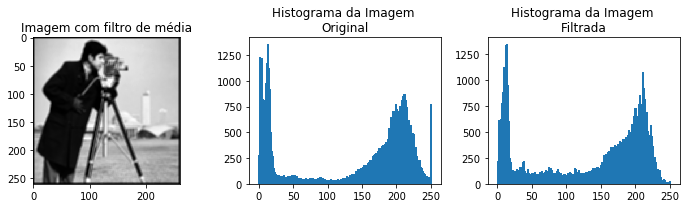

In [22]:
V = np.ones(25).reshape(5,5)
V = V/25

#histograma original
hyt = ia.histogram(yt)


img_blur =  ia.conv(yt,V).astype('int64')
#print(img_blur.shape)
#print(img_blur.max())
h_blur = ia.histogram(img_blur)
#print(h_blur.shape)
#print(h_blur.size)

limiar2, b2 = otsu(img_blur)
print(f"limiar obtido: {limiar2}")


plt.figure(figsize= (10,3))
plt.subplot(131)
plt.title('Imagem com filtro de média')
plt.imshow(img_blur,'gray')
plt.subplot(132)
plt.title('Histograma da Imagem \nOriginal')
plt.bar(np.arange(hyt.size),hyt,width=3)

plt.subplot(133)
plt.title('Histograma da Imagem \nFiltrada')
#plt.imshow(img_blur,'gray')
#plt.subplot(144)

plt.bar(np.arange(h_blur.size),h_blur,width=3)

plt.tight_layout()


Se observamos o histograma após a aplicação do filtro, notamos que há uma melhoria na definição dos picos, o que favorece a aplicação do algoritmo para a obtenção do limiar de Otsu.

Vamos agora utilizar o valor obtido com a limiarização de otsu para fazer a segmentação da imagem da parte 1, e comparar os resultados. 

155 0.6937100218301585


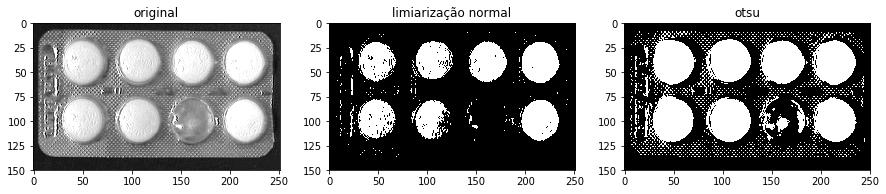

In [60]:
lim_otsu,et0 = otsu(img2)
print(lim_otsu,et0)

seg_otsu = img2 > lim_otsu


plt.figure(figsize = (15,15))
plt.subplot(131)
plt.title('original')
plt.imshow(img2,'gray')
plt.subplot(132)
plt.title('limiarização normal')
plt.imshow(seg1,'gray')
plt.subplot(133)
plt.title('otsu')
plt.imshow(seg_otsu,'gray')


Comparando as imagens acima, notamos que a limiarização de otsu não separou bem a cartela do fundo ou dos comprimidos. Isso ocorreu porque o histograma da imagem possuia uma distribuição que não era bimodal (ao invés de dois picos, ele possuia 3, que correspondiam ao fundo, à cartela, e aos comprimidos. Nesse caso,a limiarização de otsu não se mostrou muito eficiente.

<BarContainer object of 256 artists>

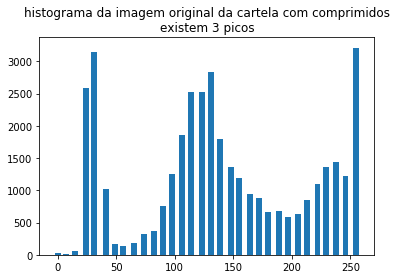

In [136]:
plt.title('histograma da imagem original da cartela com comprimidos\nexistem 3 picos')
plt.bar(x,h2,width=5)

### Parte 3 - Segmentação por watershed

Tentem reproduzir a demonstração de segmentação por watershed da antiga toolbox ([pdf](../data/ia870_iadbeef.pdf)). Vocês podem usar as funções de watershed implementadas na biblioteca *scipy.ndimage.measurements* ou *skimage.morphology*. Você pode também se inspirar no Seminário do Eduardo ([link](./Seminarios/Watershed.ipynb)).
Quem quiser conhecer todos os algoritmos da Transformada de Watershed, eles estão descritos na Toolbox de Watershed desenvolvida por um de nossos alunos ([Toolbox Watershed](http://adessowiki.fee.unicamp.br/adesso/wiki/watershed/view/))

Vamos tentar utilizar a biblioteca skimage para fazer a segmentação da imagem.

A implementação do código foi retirada do exemplo da própria biblioteca, disponível em:

http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_marked_watershed.html#sphx-glr-auto-examples-segmentation-plot-marked-watershed-py

Também foi realizada uma consulta ao livro *"Compyter Vision with Python 3"*, de *Saurabh Kapur*, que continha procedimentos semelhantes utilizando a biblioteca skimage.

(258, 380, 4)


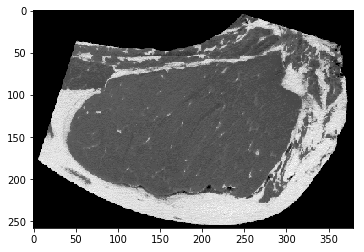

In [137]:
beef = mpimg.imread('../data/beef.tif')
plt.imshow(beef,'gray')
print(beef.shape)

O fato do shape da imagem não ser simplesmente bidimensional implica na necessidade de pré-processamento para adequá-la a um formato aceitável para a aplicação do watershed.

(256,)


<BarContainer object of 256 artists>

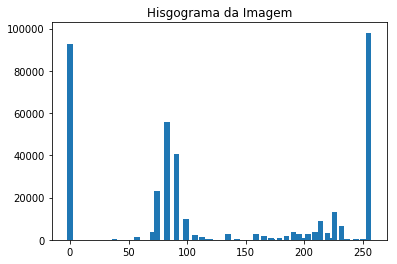

In [133]:
beefn = ia.normalize(beef,[0,255])

hbeef = ia.histogram(beefn)
print(hbeef.shape)

x = np.arange(256)

plt.title("Hisgograma da Imagem")
plt.bar(x,hbeef,width=5)

A análise do histograma vai nos ajudar a ter uma ideia melhor da distribuição de níveis de cinza

(258, 380, 4)


/home/marcio/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


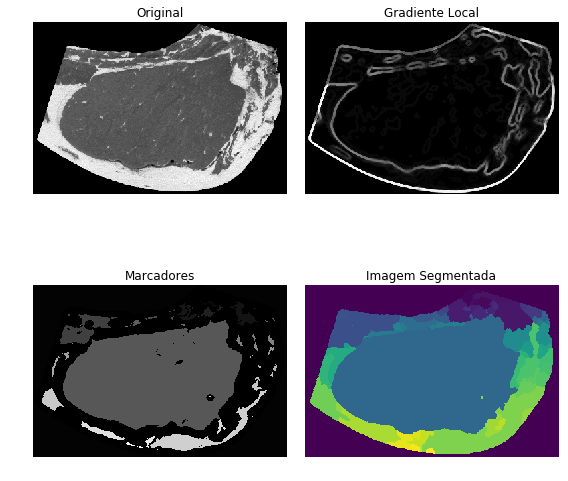

In [140]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = mpimg.imread('../data/beef.tif')
print(image.shape)
image = rgb2gray(image)
image = img_as_ubyte(image)

# uso de um filtro de mediana para retirada de ruido da imagem
denoised = rank.median(image, disk(5))

# em seguida, é feita a busca por regiões contínuas (de baixo gradiente) 
# para a obtenção dos marcadores
# disk() é utilizada para obter uma imagem mais suave
markers = rank.gradient(denoised, disk(4)) < 10
markers = ndi.label(markers)[0]

# gradiente local (as bordas são mantidas finas com o uso de disk(2))
gradient = rank.gradient(denoised, disk(2))

# uso do watershed
labels = watershed(gradient, markers)

# exibição das imagens
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

#ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].imshow(image, 'gray')
ax[0].set_title("Original")

ax[1].imshow(gradient, 'gray')
ax[1].set_title("Gradiente Local")

ax[2].imshow(markers, 'gray')
ax[2].set_title("Marcadores")


#a ultima imagem ficou em cores para poder evidenciar melhor a segmentação.
ax[3].imshow(image)
ax[3].imshow(labels)
ax[3].set_title("Imagem Segmentada")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


O resultado obtido no final permitiu fazer a segmentação entre a parte interna do bife e a capa de gordura. Contudo, foram delimitadas mais do que duas ou três regiões, e eu não consegui reduzir o número de regiões para eu só restringisse a segmentação em "fundo", "gordura" e "carne" na imagem.